# Scaling PDF Retrieval with Qdrant

### Introduction to PDF Retrieval

PDF document retrieval is a common requirement in tasks like (agentic) retrieval-augmented generation (RAG) or other various search applications. However, working with PDF documents is usually associated with challenges. 

Many traditional PDF retrieval approaches rely on complex algorithms on top of optical character recognition (OCR) solutions and use case-specific heuristics to handle visually complex elements in PDF documents like tables, images and charts. These algorithms are often non-transferable even within the same domain with their task-customized parsing and chunking strategies, labor-intensive, prone to errors, and difficult to scale.

Recent advancements in Vision Large Language Models (VLLMs), such as [**ColPali**](https://huggingface.co/blog/manu/colpali) and its successor [**ColQwen**](https://huggingface.co/vidore/colqwen2-v0.1), started the transformation of the PDF retrieval. These multimodal models work directly with PDF pages as inputs, no pre-processing required. Anything that can be converted into an **image** (think of PDFs as screenshots of document pages) can be effectively processed by these models. Being far simpler in use, VLLMs achieve state-of-the-art performance in PDF retrieval benchmarks like the [Visual Document Retrieval (ViDoRe) Benchmark](https://huggingface.co/spaces/vidore/vidore-leaderboard).

### How VLLMs Work for PDF Retrieval

VLLMs like **ColPali** and **ColQwen** generate **multivector representations** for each PDF page; the representations are stored and indexed in a vector database. During the retrieval process, models dynamically create multivector representations for (textual) user queries, and retrieval -- matching between PDF pages and queries -- is achieved through [late-interaction mechanism](https://qdrant.tech/blog/qdrant-colpali/#how-colpali-works-under-the-hood).

> **Note:** Qdrant supports [multivector representations](https://qdrant.tech/documentation/concepts/vectors/#multivectors), making it well-suited for using embedding models such as ColPali, ColQwen, or [ColBERT](https://qdrant.tech/documentation/fastembed/fastembed-colbert/).

### Challenges of Scaling VLLMs

The heavy multivector representations produced by models like **ColPali** or **COlQwen** make PDF retrieval at scale computationally intensive. These models are inefficient for large-scale PDF retrieval tasks if used without optimization.

### Math Behind the Scaling

**ColPali** generates over **1,000 vectors per PDF page**, while its successor, **ColQwen**, generates slightly fewer — up to **768 vectors**, dynamically adjusted based on the image size. Typically, ColQwen produces **~700 vectors per page**.

To understand the impact, consider the construction of an [**HNSW index**](https://qdrant.tech/articles/what-is-a-vector-database/#1-indexing-hnsw-index-and-sending-data-to-qdrant), a common indexing algorithm for vector databases. Although HNSW optimizes comparisons, let’s assume a worst-case scenario where every vector is compared to every other vector to build the index.

Example:
- **Number of pages:** 20,000
- **Vectors per page:** ~700 (ColQwen) or ~1,000 (ColPali)
- **Vector dimensions:** 128

The number of comparisons required to construct the index for ColQwen is:

$$
700 \times 700 \times 128 \times 20,000 = 1.25 \, \text{trillion comparisons!}
$$

For ColPali, this number nearly doubles. It leads to:
1. **Slow Index Construction:** Building or updating the index takes an immense amount of time.
2. **Inefficient Retrieval:** Even with a successfully constructed index, retrieval times are slow.

### Our Solution

To optimize retrieval with these VLLMs, we recommend reducing the number of vectors in a PDF page’s representation for the **first-stage retrieval**. After performing the first stage retrieval with a reduced amount of vectors, we propose to rerank retrieved results with the original page representation.

The reduction of vectors can be achieved by applying a **mean pooling operation** to the multivector outputs generated by **ColPali** or **ColQwen**. These models produce vectors corresponding to patches that represent different portions of a PDF page. 

Mean pooling averages the values across all vectors within a selected group, condensing multiple vectors into a single representative vector. If done right, it allows the preservation of important information from the original page while significantly reducing the number of vectors.

For example:
- ColPali divides PDF page into **1,024 patches**.
- Applying mean pooling by rows (or columns) of this patch matrix reduces the page representation to just **32 vectors**.

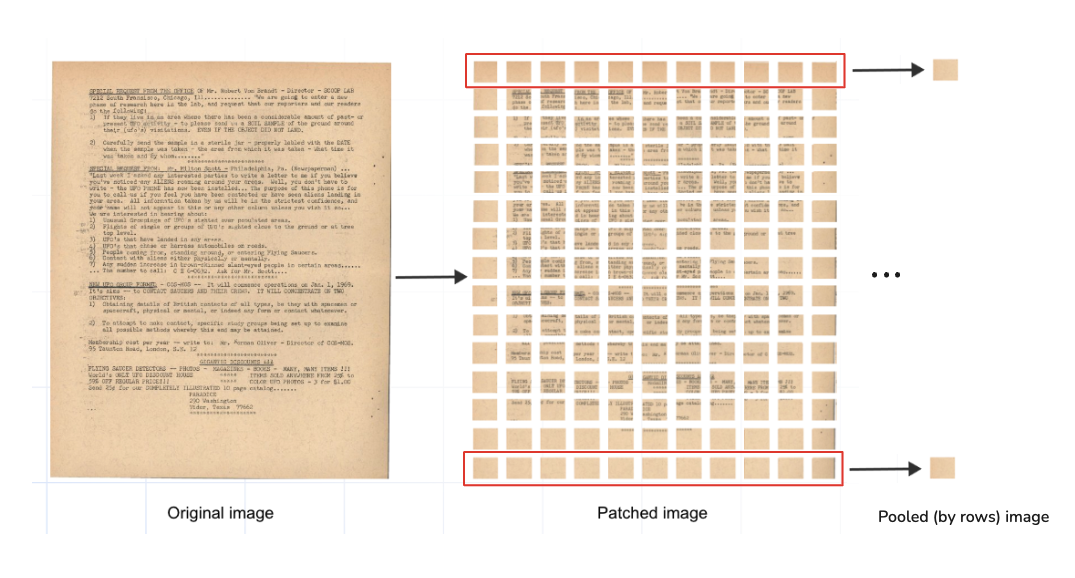

We tested this approach with the ColPali model, mean-pooling its embeddings by PDF page rows. The results showed:
- **13x speedup in retrieval time.**
- **Retrieval quality comparable to the original model**

For details of this experiment refer to our [gitHub repository](https://github.com/qdrant/demo-colpali-optimized), [ColPali optimization blog post](https://qdrant.tech/blog/colpali-qdrant-optimization/) or [webinar "PDF Retrieval at Scale"](https://www.youtube.com/watch?v=_h6SN1WwnLs)

### Flexibility in Application

1. **Pooling by rows or columns:** While our experiments tested pooling by rows, pooling by columns may be more effective for certain datasets or use cases. Both approaches are included in this tutorial.
   
2. **Applicability to ColQwen:** Although our experiments were conducted on ColPali, we believe the same approach applies to ColQwen. This tutorial includes instructions for optimizing retrieval with both models.

### Goal of This Tutorial

In this tutorial, we will demonstrate a scalable approach to PDF retrieval using Qdrant and ColPali&ColQwen VLLMs.
The presented approach is highly recommended to avoid the common pitfalls of long indexing times and slow retrieval speeds.

In the following sections, we will demonstrate an optimized retrieval algorithm born out of our successful experimentation:

**First-Stage Retrieval with Mean-Pooled Vectors:**
   - Construct an HNSW index using **only mean-pooled vectors**.
   - Use them for the first-stage retrieval

**Reranking with Original Model Multivectors:**
   - Use the original vectors from ColPali or ColQwen **to rerank** the top results retrieved in the first stage.

### Setup
Install & import required libraries

In [1]:
!pip install -q "qdrant-client" "colpali_engine>=0.3.1" "datasets" "huggingface_hub[hf_transfer]" "transformers>=4.45.0"

In [288]:
from colpali_engine.models import ColPali, ColPaliProcessor, ColQwen2, ColQwen2Processor
from datasets import load_dataset 
from qdrant_client import QdrantClient
from qdrant_client.http import models
import torch
from tqdm import tqdm
import uuid
import random

To run these experiments, we’re using a **Qdrant cluster**. If you’re just getting started, you can set up a **free-tier cluster** for testing and exploration. Follow the instructions in the documentation ["How to Create a Free-Tier Qdrant Cluster"](https://qdrant.tech/documentation/cloud/create-cluster/?q=free+tier#free-clusters)

In [176]:
client = QdrantClient(
    url=<YOUR CLUSTER URL>,
    api_key=<YOUR API KEY>
)

Download **ColQwen** and **ColPali** models along with their input processors. Make sure to select the backend that suits your setup.

In [4]:
colqwen_model = ColQwen2.from_pretrained(
        "vidore/colqwen2-v0.1",
        torch_dtype=torch.bfloat16,
        device_map="mps", # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
    ).eval()

colqwen_processor = ColQwen2Processor.from_pretrained("vidore/colqwen2-v0.1")

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [6]:
colpali_model = ColPali.from_pretrained(
        "vidore/colpali-v1.3",
        torch_dtype=torch.bfloat16,
        device_map="mps",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
    ).eval()

colpali_processor = ColPaliProcessor.from_pretrained("vidore/colpali-v1.3")

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/423 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

### Create Qdrant Collections

We will create two separate collections: one for the **ColQwen** model and one for the **ColPali** model. Each collection will include options for **mean pooling** by rows and columns of the PDF page representations.

> **Important:** For the original multivectors generated by the models, we will disable HNSW index construction. The HNSW index is unnecessary for reranking and insufficient for large datasets encoded in original models' representations, as discussed earlier.


In [309]:
colpali_collection_name = "colpali_tutorial"

client.create_collection(
    collection_name=colpali_collection_name,
    vectors_config={
        "original":
            models.VectorParams( #switch off HNSW
                  size=128,
                  distance=models.Distance.COSINE,
                  multivector_config=models.MultiVectorConfig(
                      comparator=models.MultiVectorComparator.MAX_SIM
                  ),
                  hnsw_config=models.HnswConfigDiff(
                      m=0 #switching off HNSW
                  )
            ),
        "mean_pooling_columns": models.VectorParams(
                size=128,
                distance=models.Distance.COSINE,
                multivector_config=models.MultiVectorConfig(
                    comparator=models.MultiVectorComparator.MAX_SIM
                )
            ),
        "mean_pooling_rows": models.VectorParams(
                size=128,
                distance=models.Distance.COSINE,
                multivector_config=models.MultiVectorConfig(
                    comparator=models.MultiVectorComparator.MAX_SIM
                )
            )
    }
)

True

In [313]:
colqwen_collection_name = "colqwen_tutorial"

client.create_collection(
    collection_name=colqwen_collection_name,
    vectors_config={
        "original": 
            models.VectorParams( #switch off HNSW
                  size=128,
                  distance=models.Distance.COSINE,
                  multivector_config=models.MultiVectorConfig(
                      comparator=models.MultiVectorComparator.MAX_SIM
                  ),
                  hnsw_config=models.HnswConfigDiff(
                      m=0 #switching off HNSW
                  )
            ),
        "mean_pooling_columns": models.VectorParams(
                size=128,
                distance=models.Distance.COSINE,
                multivector_config=models.MultiVectorConfig(
                    comparator=models.MultiVectorComparator.MAX_SIM
                )
            ),
        "mean_pooling_rows": models.VectorParams(
                size=128,
                distance=models.Distance.COSINE,
                multivector_config=models.MultiVectorConfig(
                    comparator=models.MultiVectorComparator.MAX_SIM
                )
            )
    }
)

True

### Choose a dataset

We’ll use the **UFO Dataset** by Daniel van Strien for this tutorial. It’s available on Hugging Face; you can download it directly from there. 

In [173]:
ufo_dataset = "davanstrien/ufo-ColPali"
dataset = load_dataset(ufo_dataset, split="train")

Generating train split:   0%|          | 0/2243 [00:00<?, ? examples/s]

### Embedding and Mean Pooling

We'll use a function that generates multivector representations and their mean pooled versions of each PDF page (aka image) in batches.
For complete understanding, it's important to consider the following specifics of **ColPali** and **ColQwen**:

#### ColPali
In theory, ColPali is designed to generate **1,024 vectors per PDF page**, but in practice, it produces **1,030 vectors**. This discrepancy is due to ColPali's pre-processor, which appends the text `<bos>Describe the image.` to each input. This additional text generates an extra **6 multivectors**.

#### ColQwen
ColQwen dynamically determines the number of patches in "rows and columns" of a PDF page based on its size. Consequently, the number of multivectors can vary between inputs. ColQwen prepends `<|im_start|>user<|vision_start|>` and appends `<|vision_end|>Describe the image.<|im_end|><|endoftext|>`.

For our experiments, we chose to **preserve these additional vectors**. Our pooling operation compresses the multivectors representing the image tokens based on the number of rows and columns determined by the model (static 32x32 for ColPali, dynamic XxY for ColQwen). Function retains and integrates the additional multivectors produced by the model back to pooled representations.

In [304]:
def get_patches(image_size, model_processor, model, model_name):
    if model_name == "colPali":
        return model_processor.get_n_patches(image_size, 
                                             patch_size=model.patch_size)
    elif model_name == "colQwen":
        return model_processor.get_n_patches(image_size, 
                                             patch_size=model.patch_size,
                                             spatial_merge_size=model.spatial_merge_size)
    return None, None

def embed_and_mean_pool_batch(image_batch, model_processor, model, model_name):
    #embed
    with torch.no_grad():
        processed_images = model_processor.process_images(image_batch).to(model.device) 
        image_embeddings = model(**processed_images)

    image_embeddings_batch = image_embeddings.cpu().float().numpy().tolist()
    
    #mean pooling
    pooled_by_rows_batch = []
    pooled_by_columns_batch = []
    
    
    for image_embedding, tokenized_image, image in zip(image_embeddings, 
                                                       processed_images.input_ids, 
                                                       image_batch):
        x_patches, y_patches = get_patches(image.size, model_processor, model, model_name)
        #print(f"{model_name} model divided this PDF page in {x_patches} rows and {y_patches} columns")

        image_tokens_mask = (tokenized_image == model_processor.image_token_id)
        
        image_tokens = image_embedding[image_tokens_mask].view(x_patches, y_patches, model.dim)
        pooled_by_rows = torch.mean(image_tokens, dim=0)
        pooled_by_columns = torch.mean(image_tokens, dim=1)

        image_token_idxs = torch.nonzero(image_tokens_mask.int(), as_tuple=False)
        first_image_token_idx = image_token_idxs[0].cpu().item()
        last_image_token_idx = image_token_idxs[-1].cpu().item()
        
        prefix_tokens = image_embedding[:first_image_token_idx]
        postfix_tokens = image_embedding[last_image_token_idx + 1:]
        
        #print(f"There are {len(prefix_tokens)} prefix tokens and {len(postfix_tokens)} in a {model_name} PDF page embedding")

        #adding back prefix and postfix special tokens
        pooled_by_rows = torch.cat((prefix_tokens, pooled_by_rows, postfix_tokens), dim=0).cpu().float().numpy().tolist()
        pooled_by_columns = torch.cat((prefix_tokens, pooled_by_columns, postfix_tokens), dim=0).cpu().float().numpy().tolist()
        
        pooled_by_rows_batch.append(pooled_by_rows)
        pooled_by_columns_batch.append(pooled_by_columns)


    return image_embeddings_batch, pooled_by_rows_batch, pooled_by_columns_batch

### Batch uploading to Qdrant
Below is the function to batch upload multivectors into the collections created earlier in Qdrant.

In [ ]:
def upload_batch(original_batch, pooled_by_rows_batch, pooled_by_columns_batch, payload_batch, collection_name):
    try:
        client.upsert(
            collection_name=collection_name,
            points=models.Batch( #batch upsert
                ids=[str(uuid.uuid4()) for i in range(len(original_batch))],
                payloads=payload_batch,
                vectors={
                    "mean_pooling_columns": pooled_by_columns_batch,
                    "original": original_batch,
                    "mean_pooling_rows": pooled_by_rows_batch
                    }
            )
        )
    except Exception as e:
        print(f"Error during upsert: {e}")

After selecting a batch size that matches your compute, you can test the uploading process of the **UFO dataset**, pre-processed according to our approach by `embed_and_mean_pool_batch` function.

In [311]:
batch_size = 1 
dataset_source = ufo_dataset
collection_name = "colpali_tutorial"

with tqdm(total=len(dataset), desc=f"Uploading progress of \"{dataset_source}\" dataset to \"{collection_name}\" collection") as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]
        image_batch = batch["image"]
        current_batch_size = len(image_batch)
        try:
            original_batch, pooled_by_rows_batch, pooled_by_columns_batch = embed_and_mean_pool_batch(image_batch, 
                                                                                          colpali_processor, 
                                                                                          colpali_model, 
                                                                                          "colPali")
        except Exception as e:
            print(f"Error during embed: {e}")
            continue
        try:
            upload_batch(
                original_batch,
                pooled_by_rows_batch,
                pooled_by_columns_batch,
                [
                    {
                        "source": dataset_source, 
                        "index": j
                    }
                    for j in range(i, i + current_batch_size)
                ],
                collection_name
            )
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue
        # Update the progress bar
        pbar.update(current_batch_size)
print("Uploading complete!")

Uploading progress of "davanstrien/ufo-ColPali" dataset to "colpali_tutorial" collection:  65%|█████████████████████████████████████████████████████████████████████                                     | 1462/2243 [2:06:43<62:36:11, 288.57s/it]

Error during upsert: Server disconnected without sending a response.


Uploading progress of "davanstrien/ufo-ColPali" dataset to "colpali_tutorial" collection:  68%|█████████████████████████████████████████████████████████████████████████▍                                  | 1524/2243 [2:12:28<1:08:11,  5.69s/it]

Error during upsert: The write operation timed out


Uploading progress of "davanstrien/ufo-ColPali" dataset to "colpali_tutorial" collection: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2243/2243 [3:04:48<00:00,  4.94s/it]

Uploading complete!


In [314]:
batch_size = 1 #based on GPU's
dataset_source = ufo_dataset
collection_name = "colqwen_tutorial"

with tqdm(total=len(dataset), desc=f"Uploading progress of \"{dataset_source}\" dataset to \"{collection_name}\" collection") as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i : i + batch_size]
        image_batch = batch["image"]
        current_batch_size = len(image_batch)
        try:
            original_batch, pooled_by_rows_batch, pooled_by_columns_batch = embed_and_mean_pool_batch(image_batch, 
                                                                                          colqwen_processor, 
                                                                                          colqwen_model, 
                                                                                          "colQwen")
        except Exception as e:
            print(f"Error during embed: {e}")
            continue
        try:
            upload_batch(
                original_batch,
                pooled_by_rows_batch,
                pooled_by_columns_batch,
                [
                    {
                        "source": dataset_source, 
                        "index": j
                    }
                    for j in range(i, i + current_batch_size)
                ],
                collection_name
            )
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue
        # Update the progress bar
        pbar.update(current_batch_size)
print("Uploading complete!")

Uploading progress of "davanstrien/ufo-ColPali" dataset to "colqwen_tutorial" collection:  14%|███████████████▍                                                                                                 | 307/2243 [24:17<2:33:10,  4.75s/it]

Error during upsert: Unexpected Response: 502 (Bad Gateway)
Raw response content:
b'Bad Gateway'


Uploading progress of "davanstrien/ufo-ColPali" dataset to "colqwen_tutorial" collection:  43%|███████████████████████████████████████████████▊                                                               | 967/2243 [1:28:17<1:48:15,  5.09s/it]

Error during upsert: Unexpected Response: 502 (Bad Gateway)
Raw response content:
b'Bad Gateway'


Uploading progress of "davanstrien/ufo-ColPali" dataset to "colqwen_tutorial" collection: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2243/2243 [3:43:44<00:00,  5.99s/it]

Uploading complete!


### Querying PDFs

After indexing PDF documents, we can move on to querying them using our two-stage retrieval approach.


In [292]:
def batch_embed_query(query_batch, model_processor, model): #per query
    with torch.no_grad():
        processed_queries = model_processor.process_queries(query_batch).to(model.device)
        query_embeddings_batch = model(**processed_queries)
    return query_embeddings_batch.cpu().float().numpy()

Let's select some random batch of queries from "UFO dataset"

In [334]:
query_batch = random.sample(dataset['specific_detail_query'], 4)
colpali_query_batch = batch_embed_query(query_batch, colpali_processor, colpali_model)
colqwen_query_batch = batch_embed_query(query_batch, colqwen_processor, colqwen_model)

print(f"ColPali embedded query \"{query_batch[0]}\" with {len(colpali_query_batch[0])} multivectors of dim {len(colpali_query_batch[0][0])}")
print(f"ColQwen embedded query \"{query_batch[0]}\" with {len(colqwen_query_batch[0])} multivectors of dim {len(colqwen_query_batch[0][0])}")

ColPali embedded query "Lee Harvey Oswald's involvement in the JFK assassination" with 27 multivectors of dim 128
ColQwen embedded query "Lee Harvey Oswald's involvement in the JFK assassination" with 25 multivectors of dim 128


Here’s how two-stage retrieval with embeddings produced by VLLMs works:

- **Step 1:** Prefetch results using a smaller multi-vector representation on the built index.
- **Step 2:** Re-rank the pre-fetched results using the original multi-vector representation produced by the model.

This search process also supports batch queries.

In [335]:
def reranking_search_batch(query_batch,
                           named_vector_prefetch,
                           collection_name,
                           search_limit=20,
                           prefetch_limit=200,
                           timeout=10):
    search_queries = [
      models.QueryRequest(
          query=query,
          prefetch=models.Prefetch(
              query=query,
              limit=prefetch_limit,
              using=named_vector_prefetch
          ),
          params=models.SearchParams(
              exact=True
          ),
          limit=search_limit,
          with_payload=True,
          with_vector=False,
          using="original"
      ) for query in query_batch
    ]
    return client.query_batch_points(
        collection_name=collection_name,
        requests=search_queries,
        timeout=timeout
    )

Let's query our collections using mean-pooled by columns representations for the first stage of retrieval.

In [322]:
batch_answer_colpali = reranking_search_batch(colpali_query_batch, "mean_pooling_columns", "colpali_tutorial")
batch_answer_colqwen = reranking_search_batch(colqwen_query_batch, "mean_pooling_columns", "colqwen_tutorial")

We can see that both **ColPali** and **ColQwen** return the correct result.

In [323]:
batch_answer_colpali[0].points[0]

ScoredPoint(id='60d61b8f-a80b-461f-bc57-cc81113d5487', version=726, score=16.44797, payload={'source': 'davanstrien/ufo-ColPali', 'index': 726}, vector=None, shard_key=None, order_value=None)

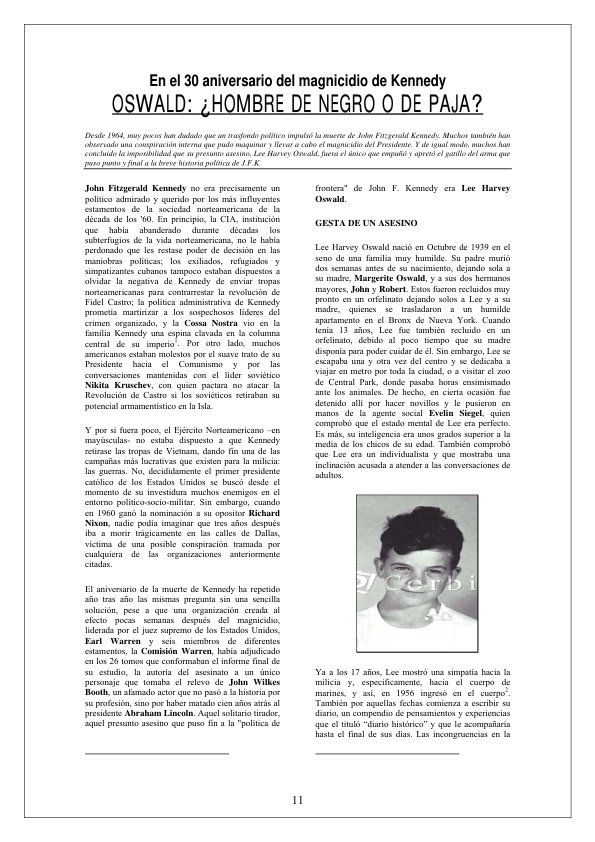

In [325]:
dataset[batch_answer_colpali[0].points[0].payload['index']]['image']

In [324]:
batch_answer_colqwen[0].points[0]

ScoredPoint(id='7c518cdb-a8cb-46dd-bd52-83edbc7ec901', version=725, score=14.695495, payload={'source': 'davanstrien/ufo-ColPali', 'index': 726}, vector=None, shard_key=None, order_value=None)

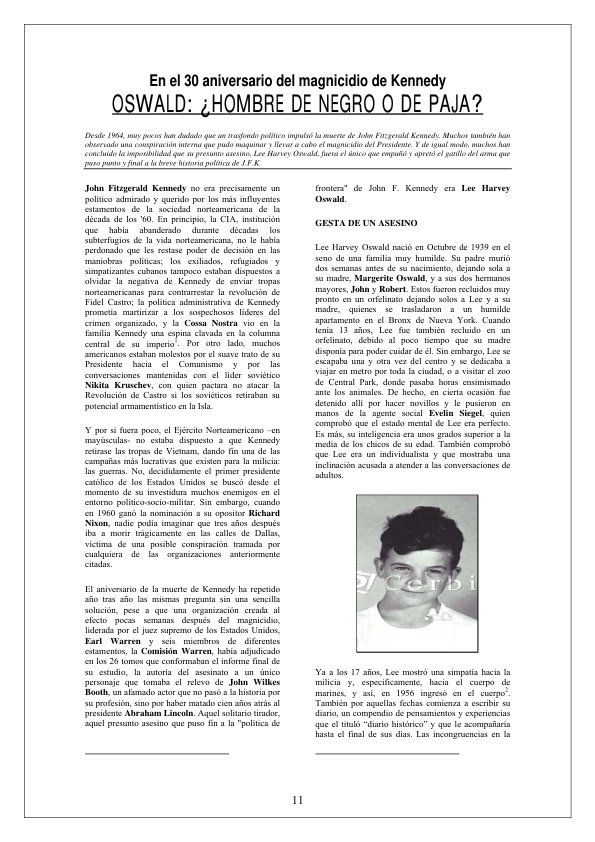

In [326]:
databset[batch_answer_colqwen[0].points[0].payload['index']]['image']

### Conclusion

In this tutorial, we demonstrated an optimized approach using **Qdrant for PDF retrieval at scale** with VLLMs producing **heavy multivector representations** like **ColPali** and **ColQwen**.

Without such optimization, the performance of retrieval systems can degrade severely, both in terms of indexing time and query latency, especially as the dataset size grows.

We **strongly recommend** implementing this approach in your workflows to ensure efficient and scalable PDF retrieval. Neglecting to optimize the retrieval process could result in unacceptably slow performance, hindering the usability of your system.

Start scaling your PDF retrieval today!
